In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)
import collections
import numpy as np
import pandas as pd
import re
import string
import scipy as sp
import gensim
import gensim.downloader as api
import nltk, nltk.data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import wordnet
from tqdm.notebook import tqdm
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from argparse import Namespace

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 640x640 with 0 Axes>

time: 30.9 ms (started: 2021-10-25 13:19:50 +00:00)


In [ ]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.2 ms (started: 2021-10-25 13:19:51 +00:00)


# <center>Project 2 Natural Language for NLP</center>

<center>   

**Name_ Student number:**
<br>
Chanxin Xie_22566456
<br>
Yiyong Duan_22628103<br>

**Date created:** Oct 5th 2022<br>
**Last modified:** Oct 25th 2022<br>


## This notebook contains all details about Task 1: Binary Document Classification:


**This task follows the procedures listed below:**

1. Initial Data preparation
2. Data Prepreocessing
2. Split the training/testing/validation dataset
3. Perform word embedding
4. Group data into minibatch for the model via DataLoader
5. Train Model
6. Evaluation
7. Compare performance of two different models

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/NLP/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NLP
time: 17.6 ms (started: 2021-10-25 13:19:51 +00:00)


In [ ]:
# Import dataset
df_org = pd.read_csv('us_data_2000.csv')
df_org.head(2)

,MINE_ID,CONTROLLER_ID,CONTROLLER_NAME,OPERATOR_ID,OPERATOR_NAME,CONTRACTOR_ID,DOCUMENT_NO,SUBUNIT_CD,SUBUNIT,ACCIDENT_DT,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,ACCIDENT_TIME,DEGREE_INJURY_CD,DEGREE_INJURY,FIPS_STATE_CD,UG_LOCATION_CD,UG_LOCATION,UG_MINING_METHOD_CD,UG_MINING_METHOD,MINING_EQUIP_CD,MINING_EQUIP,EQUIP_MFR_CD,EQUIP_MFR_NAME,EQUIP_MODEL_NO,SHIFT_BEGIN_TIME,CLASSIFICATION_CD,CLASSIFICATION,ACCIDENT_TYPE_CD,ACCIDENT_TYPE,NO_INJURIES,TOT_EXPER,MINE_EXPER,JOB_EXPER,OCCUPATION_CD,OCCUPATION,ACTIVITY_CD,ACTIVITY,INJURY_SOURCE_CD,INJURY_SOURCE,NATURE_INJURY_CD,NATURE_INJURY,INJ_BODY_PART_CD,INJ_BODY_PART,SCHEDULE_CHARGE,DAYS_RESTRICT,DAYS_LOST,TRANS_TERM,RETURN_TO_WORK_DT,IMMED_NOTIFY_CD,IMMED_NOTIFY,INVEST_BEGIN_DT,NARRATIVE,CLOSED_DOC_NO,COAL_METAL_IND
0,100003,41044,Lhoist Group,L13586,Lhoist North America,NaN,2.201210e+11,3,"STRIP, QUARY, OPEN PIT",14/03/2012,2012,1,2012,2,945,5,DAYS RESTRICTED ACTIVITY ONLY,1,?,NO VALUE FOUND,?,NO VALUE FOUND,24,"Front-end loader, Tractor-shovel, Payloader, H...",119,Not on this list,22321,600.0,12,POWERED HAULAGE,21,"CGHT I, U, B, MVNG & STTN OBJS",1,4.35,4.35,0.67,374,"Warehouseman, Bagger, Palletizer/Stacker, Stor...",28,HANDLING SUPPLIES/MATERIALS,76,SURFACE MINING MACHINES,160,"CONTUSN,BRUISE,INTAC SKIN",700,MULTIPLE PARTS (MORE THAN ONE MAJOR),0.0,8.0,0.0,N,03/26/2012,?,NO VALUE FOUND,NaN,Employee was cleaning up at the Primary Crushe...,NaN,M
1,100003,41044,Lhoist Group,L13586,Lhoist North America,NaN,2.200700e+11,30,MILL OPERATION/PREPARATION PLANT,8/01/2007,2007,1,2007,2,1105,6,"NO DYS AWY FRM WRK,NO RSTR ACT",1,?,NO VALUE FOUND,?,NO VALUE FOUND,28,Hand tools (not powered),121,Not Reported,NaN,700.0,10,HANDTOOLS (NONPOWERED),8,"STRUCK BY, NEC",1,0.02,0.02,0.02,374,"Warehouseman, Bagger, Palletizer/Stacker, Stor...",30,HAND TOOLS (NOT POWERED),46,"AXE,HAMMER,SLEDGE",180,"CUT,LACER,PUNCT-OPN WOUND",100,"HEAD,NEC",0.0,0.0,0.0,N,1/09/2007,?,NO VALUE FOUND,NaN,Handle of sledgehammer broke and head of hamme...,NaN,M


time: 154 ms (started: 2021-10-25 13:19:51 +00:00)


## 1 Initial Data preparation
This task is to clean up the original dataset so that we can use the NARRATIVE text field to predict the degree of injury (DEGREE_INJURY). 
1. Initial cleaning up
2. Class Determination -- We make use the degree of injury code (DEGREE_INJURY_CD) to group injuries into two categories and assign the corresponding class to each row. 


### 1.1 Clean up data

As the goal is to use the NARRATIVE text field to predict the degree of injury (DEGREE_INJURY), we extract column 'DEGREE_INJURY_CD' and 'NARRATIVE' from the original dataset and remove the values in 'DEGREE_INJURY_CD' which cannot be classified.

In [ ]:
# subset data to get column 'DEGREE_INJURY_CD','NARRATIVE'
df = df_org[['DEGREE_INJURY_CD','NARRATIVE']]
# remove value '?' in column 'DEGREE_INJURY_CD'
df = df[df.DEGREE_INJURY_CD != '?']

time: 12.5 ms (started: 2021-10-25 13:19:51 +00:00)


### 1.2 Class Determination

#### 1.2.1 Investigation

From the pivot table below, we can see the relationship between 'DEGREE_INJURY' and their corresponding 'DEGREE_INJURY_CD' as well as their distribution. We notice that they could be classified by the degree of injury code. And they can be seperated roughly into two groups: severe and light.

In [ ]:
df_pivot = df_org[['DEGREE_INJURY','DEGREE_INJURY_CD']]
# Firstly, we check up the dataframe by creating a pivot table with DEGREE_INJURY_CD and DEGREE_INJURY.
pd.pivot_table(df_pivot, values = 'DEGREE_INJURY_CD', index = 'DEGREE_INJURY', columns= ['DEGREE_INJURY_CD'], aggfunc=lambda x:len(x))

DEGREE_INJURY_CD,0,1,10,2,3,4,5,6,7,8,9,?
DEGREE_INJURY,,,,,,,,,,,,
ACCIDENT ONLY,219.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALL OTHER CASES (INCL 1ST AID),NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYS AWAY FROM WORK ONLY,NaN,NaN,NaN,NaN,595.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DAYS RESTRICTED ACTIVITY ONLY,NaN,NaN,NaN,NaN,NaN,NaN,359.0,NaN,NaN,NaN,NaN,NaN
DYS AWY FRM WRK & RESTRCTD ACT,NaN,NaN,NaN,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN
FATALITY,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INJURIES DUE TO NATURAL CAUSES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN
INJURIES INVOLVNG NONEMPLOYEES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
"NO DYS AWY FRM WRK,NO RSTR ACT",NaN,NaN,NaN,NaN,NaN,NaN,NaN,552.0,NaN,NaN,NaN,NaN


time: 45.8 ms (started: 2021-10-25 13:19:51 +00:00)


As 'ACCIDENT ONLY' doesn't fit any senarios, we checked their corresponding NARRATIVE contexts below to make the decision.
<br>
From the samples below, we find that most of the ACCIDENT ONLY are related to accident report and light injured degree, so it should be classified as 'light'. 

In [ ]:
# Look over ACCIDENT ONLY context in NARRATIVE.
cnt = 5
for i in range(len(df_org.DEGREE_INJURY)):
    if df_org.DEGREE_INJURY[i] == 'ACCIDENT ONLY':
        print(df_org.NARRATIVE[i],'\n')
        cnt-=1
    if cnt ==1:
        break

A ROOF FALL HAS OCCURRED IN THE L-5 ROOMS IN THE #2 (TRACK ENTRY) INBY SPAD #5+20. THE FALL IS IN AN INTERSECTION AND IS APPROX. 45' LONG, 18' WIDE & 8-10' HIGH. 

A roof fall occurred in the intersection of the #2 entry of J-main #2 at spad 41+05. The fall measured approx. 100' x 20' x 6'. The fall did extend beyond the horizon of the anchor bolts. 

The Cedar Creek elevator was out of service from 3:15 pm to 3:58 pm on 5/24/07 due to a door malfunction. 

The Cedar Creek Elevator was out of service from 6:53 am until 9:46 am due to an auxilary brake contactor fault. 

time: 11.2 ms (started: 2021-10-25 13:19:51 +00:00)


#### 1.2.2 Decide two classes 

1. Based on the principal of class balance, we classify 'DEGREE_INJURY' as severe where 'DEGREE_INJURY_CD' is 1-5, and light where 'DEGREE_INJURY_CD' is 0 & 6-10.
2. From the bar-chart below, we can see that the two classes are slightly imbalanced.
3. There are 1128 instances (56.7%) in 'severe' class and 861 instances (43.3%) in 'light' class.

In [ ]:
# A function to assign to two different classes
def category(row):
    if row['DEGREE_INJURY_CD'] in ['1','2','3','4','5']:
        val = "severe"
    else:
        val = "light"
    return val

time: 4.73 ms (started: 2021-10-25 13:19:51 +00:00)


In [ ]:
# create 'classes' column based on the logic above
df['classes'] = df.apply(category, axis=1)

time: 33.2 ms (started: 2021-10-25 13:19:51 +00:00)


In [ ]:
df['classes'].value_counts()

severe    1128
light      861
Name: classes, dtype: int64

time: 10.1 ms (started: 2021-10-25 13:19:51 +00:00)


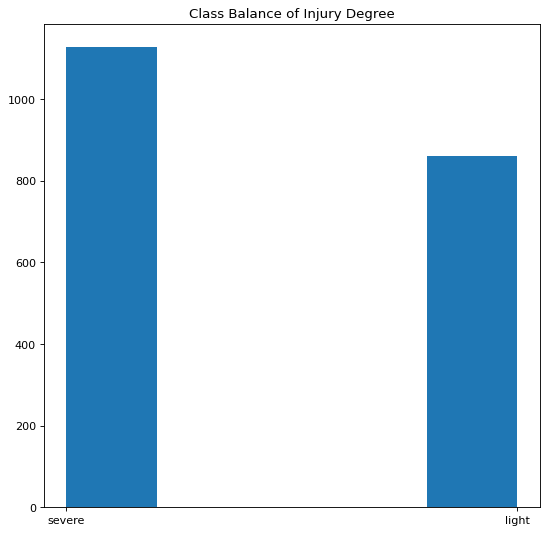

time: 145 ms (started: 2021-10-25 13:19:51 +00:00)


In [ ]:
figure(figsize=(8, 8), dpi=80)
# df["classes"].hist()
plt.hist(df["classes"], 5, density= False)
plt.title('Class Balance of Injury Degree')
plt.show()

In [ ]:
df.classes.value_counts()/len(df.classes)

severe    0.567119
light     0.432881
Name: classes, dtype: float64

time: 10.3 ms (started: 2021-10-25 13:19:52 +00:00)


The dataset looks like below after the initial cleaning up and class determination.

In [ ]:
# the table with narrative and the corresponding classes
df = df[['classes','NARRATIVE']]
df.head()

,classes,NARRATIVE
0,severe,Employee was cleaning up at the Primary Crushe...
1,light,Handle of sledgehammer broke and head of hamme...
2,severe,EMPLOYEE WAS CLIMBING DOWN A LADDER AND WHEN H...
3,severe,HE PULLED A BACK MUSCLE WHILE STACKING BAGS OF...
4,severe,EE hands began to break out in a rash after he...


time: 20.7 ms (started: 2021-10-25 13:19:52 +00:00)


## 2 Data Pre-processing

The pre-processing follows the precedures listed below:
1. Tokenize
2. Lemmatize/Stemming
3. Remove stop words based on TF/IDF - create the Dataset for each task
4. ??Create two Vectorizers for each task

### 2.1 Tokenize
Clean sentence with removing punctuations and lower case. 

In [ ]:
# Clean sentences
# Input string, output string
def remove_punc(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r'[^\w\s]','',text) # remove punctuation which is connected to words
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

time: 3.94 ms (started: 2021-10-25 13:19:52 +00:00)


In [ ]:
def clean_text(sentences):
    cleaned_sentences = [] # list of sentence, with every character of sentence.
    cleaned_sen_words = [] # list of lists of sentence, with every string of words.
    for sentence in sentences:
        cleaned_sentences.append(remove_punc(sentence))
    for sentence in cleaned_sentences:
        cleaned_sen_words.append(list(filter(None, sentence.split(' ')))) # Remove empty string of list

    return cleaned_sen_words


time: 6.5 ms (started: 2021-10-25 13:19:52 +00:00)


#### Tokenize words

In [ ]:
# Tokenize
from nltk.tokenize import word_tokenize
def tokenize(sentences):
    tokenized_words = []
    tokenized_sentences = []
    for sentence in sentences:
        temp_words = []
        for word in sentence:
            temp_words.append(' '.join(map(str, word_tokenize(word))))
            tokenized_words.append(' '.join(map(str, word_tokenize(word))))
        tokenized_sentences.append(temp_words)
    return tokenized_words, tokenized_sentences

time: 8.77 ms (started: 2021-10-25 13:19:52 +00:00)


### 2.2 Lemmatize and compare with stemming
Below lists the original sentence, the sentence after stemming and lemmatizing. We can see that sentence after Lemmatizing offers better form of words. Therefore, we chose Lemmatizing to preprocess our data.

**Original Sentence:** employee was cleaning up at the primary crusher with the dingo skid steer the employee slipped and fell while operating the skid steer and the machine pinned him against the cement retaining wall

**Stemming:** employe wa clean up at the primari crusher with the dingo skid steer the employe slip and fell while oper the skid steer and the machin pin him against the cement retain wall

**Lemmatize:** employee be clean up at the primary crusher with the dingo skid steer the employee slip and fell while operate the skid steer and the machine pin him against the cement retain wall

1. Stemming: refers to reducing a word to its root form.
<br>
Stemming:4552, Stemming(remove duplicated words): 3369 
2. Lemmatize: converts words in the second or third forms to their first form variants, so they are still dictionary words.
<br>
Lemmatize:4552, Lemmatize(remove duplicated words): 4235 


#### 2.2.1 Stemming


In [ ]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
def stem(sentences):
    stem_words = []
    stem_sentences = []
    for sentence in tokenized_sentences:
        temp_words = []
        for word in sentence:
            temp_words.append(''.join(map(str,ps.stem(word))))
            stem_words.append(''.join(map(str,ps.stem(word))))
        stem_sentences.append(temp_words)
    return stem_words, stem_sentences

time: 8.79 ms (started: 2021-10-25 13:19:52 +00:00)


#### 2.2.2 Lemmatize

Different from stemming, lemmatization requires us to access the part of speech tags (pos_tag), and restore words from different forms. 

In [ ]:
from nltk.stem import WordNetLemmatizer
word_lem = WordNetLemmatizer()

# Fetch the pos_tag function
def fetch_pos_tag(pos_tag):
    if pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    elif pos_tag.startswith('J'):
        return wordnet.ADJ
    else:
        return None

def lemma(sentences):
    lemma_words = []
    lemma_sentences = []
    for sentence in sentences:
        tagged_sent = (nltk.pos_tag(sentence)) # [('employee','NN'),('was', 'VBD'),('foreign', 'JJ')...]
        lemma_sentence = []
        for tag in tagged_sent:
            wordnet_pos = fetch_pos_tag(tag[1]) or wordnet.NOUN # if None then regard as Noun # n,v,a,r
            lemma_words.append(word_lem.lemmatize(tag[0], pos = wordnet_pos))
            lemma_sentence.append(word_lem.lemmatize(tag[0], pos = wordnet_pos))
        lemma_sentences.append(lemma_sentence)
    return lemma_words, lemma_sentences

time: 17.1 ms (started: 2021-10-25 13:19:52 +00:00)


### 2.3 Remove stop words (rank words according to TF/IDF)

#### TfidfVectorizer
For removing stop words, we used TfidfVectorizer in scikit-learn. The stop words in the narrative text were removed according to TF/IDF ranking.

In [ ]:
# Preprocessing
# Convert list of lists of sentences into list of sentences
# Example: [['Employee be drive'],['ee'],...['be here']] --> ['Employee be drive','ee',...'be here']
from sklearn.feature_extraction.text import TfidfVectorizer
def remove_stop(sentences):
    tfidf_sentences = []
    for sentence in sentences:
        word_list = []
        for word in sentence:
            word_list.append(word)
        tfidf_sentences.append(' '.join(word_list))

    tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df =0, use_idf = True) # TF-IDF vectorizer with removing 'English' stop words
    tfidf_vectors = tfidf_vectorizer.fit_transform(tfidf_sentences) # Transform sentences into vectors
    tfidf_array = tfidf_vectorizer.fit_transform(tfidf_sentences).toarray() # Transform vectors into arrays
    tfidf_matrix = tfidf_vectorizer.fit_transform(tfidf_sentences).todense() # Sent all the arrays as one matrix
    feature_names = tfidf_vectorizer.get_feature_names()
    vector_list = []

    for matrix_index in range(len(tfidf_sentences)):

        feature_index = tfidf_matrix[matrix_index,:].nonzero()[1]
        tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[matrix_index, x] for x in feature_index]) # example: tfidf_scores = ('ee',0.32132),('cement',0.1231)
        vector_list.append(dict(tfidf_scores)) # 1989 rows dictionaries with words and vector
        
    # Return terms per document with nonzero entries in array (each sentence)
    inverse_array = tfidf_vectorizer.inverse_transform(tfidf_array)
    filtered_sentences = []
    for rows in range(len(sentences)): # 1989 rows
        filtered_sentence = []
        for word in sentences[rows]:
            if word in inverse_array[rows]:
                filtered_sentence.append(word)
        filtered_sentences.append(filtered_sentence)
    return filtered_sentences, vector_list

time: 22.8 ms (started: 2021-10-25 13:19:52 +00:00)


Put all functions together 

In [ ]:
# Input NARRATIVE sentences, output preprocessed sentences
# Preprocessing includes Tokenization, Lemmatization and Removing stop words
def preprocessing(sentences, lemma_or_stem = 'lemma'):
    # Remove punctuations and lower cases
    cleaned_sen_words = clean_text(sentences)
    tokenized_words, tokenized_sentences = tokenize(cleaned_sen_words)
    if lemma_or_stem == 'lemma':
        lemma_words, lemma_sentences = lemma(tokenized_sentences)
        filtered_sentences, filtered_vector = remove_stop(lemma_sentences)
    else:
        stem_words, stem_sentences = stem(tokenized_sentences)
        filtered_sentences, filtered_vector = remove_stop(stem_sentences)
    # Convert list to string
    filtered_string = []
    for index in range(len(filtered_sentences)): # 1989
        string = ''
        for word in filtered_sentences[index]:
            string = string + word + ' '
        filtered_string.append(string)
    return filtered_string, filtered_vector

time: 12.3 ms (started: 2021-10-25 13:19:52 +00:00)


In [ ]:
filtered_column, filtered_vector = preprocessing(df['NARRATIVE'],'lemma')
# within column 'narrative' is the narrative after tokenization, lemmatisation and removing stop words
df['narrative'] = filtered_column
df['filtered_NARRATIVE_vector'] = filtered_vector

time: 13.9 s (started: 2021-10-25 13:19:52 +00:00)


## 3 Split the training/testing/validation dataset
1. In this section, we prepare the training, testing and validation dataset on a 70%,15%,15% proportion.
2. There are 1386 instances in training set, 306 in testing set and 297 in validation set.
3. Then we assign 'train','test','val' to each row and write the split dataset back to file.


In [ ]:
args = Namespace(
    window_size=5,
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="../NLP/proj2_with_splits_task1.csv",
    seed=1337
)

time: 2.62 ms (started: 2021-10-25 13:20:06 +00:00)


In [ ]:
# Create split data
n = len(df)

def get_split(row_num):
    if row_num <= n*args.train_proportion:
        return 'train'
    elif (row_num > n*args.train_proportion) and (row_num <= n*args.train_proportion + n*args.val_proportion):
        return 'val'
    else:
        return 'test'

time: 4.59 ms (started: 2021-10-25 13:20:06 +00:00)


In [ ]:
df['split']= df.apply(lambda row: get_split(row.name), axis=1)

time: 22.8 ms (started: 2021-10-25 13:20:06 +00:00)


In [ ]:
# get the needed columns for further modeling
doc = df.copy() [['classes','narrative','split']]

time: 3.77 ms (started: 2021-10-25 13:20:06 +00:00)


The dataset looks like below after the data preprocessing and train/test/validaion splitting.

In [ ]:
doc.head()

,classes,narrative,split
0,severe,employee clean primary crusher dingo skid stee...,train
1,light,handle sledgehammer broke head hammer hit empl...,train
2,severe,employee climb ladder step ground slip sprain ...,train
3,severe,pull muscle stack bag material,train
4,severe,ee hand begin break rash handle material coat ...,train


time: 19.6 ms (started: 2021-10-25 13:20:06 +00:00)


In [ ]:
# look at the number of instances for training, testing and validation set
doc['split'].value_counts()

train    1386
test      306
val       297
Name: split, dtype: int64

time: 8.15 ms (started: 2021-10-25 13:20:06 +00:00)


Write the dataset back to csv file

In [ ]:
# Write the dataset back to file
doc.to_csv(args.output_munged_csv, index=False)

time: 26.5 ms (started: 2021-10-25 13:20:06 +00:00)


## 4 Feed-forward Neural Network model

## One-Hot-Encoding
1. For this task, we implemented one-hot-encoding as our word embedding method. It is a basic method of converting the text data into numerical vectors so that we could train our model on it.

2. With one-hot-encoding, each unique word in vocabulary was represented with value 1 and the rest with 0. For each word, there is a a one-hot encoded vector, in which 1 represents the position of the word in the sentence and 0 for other words.

### 4.1 Converting Text Inputs to Vectorized Minibatches

The three classes presented in this notebook are responsible for 
- mapping each token to an integer to create a  `Vocabulary`, 
- applying this mapping to each data point to create a vectorized form using `Vectorizer`, and 
- grouping the vectorized data points into a minibatch for the model through `DataLoader`.

#### 4.1.1 Dataset

In [ ]:
from torch.utils.data import Dataset
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
        review_df (pandas.DataFrame): the dataset
        vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer
        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)
        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                            'val': (self.val_df, self.validation_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')
    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        return cls(review_df, ReviewVectorizer.from_dataframe(review_df))
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe
        Args:
        split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
    def __len__(self):
        return self._target_size
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        Args:
        index (int): the index to the data point
        Returns:
        a dict of the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]
        review_vector = \
        self._vectorizer.vectorize(row.narrative)
        rating_index = \
        self._vectorizer.rating_vocab.lookup_token(row.classes)
        return {'x_data': review_vector,
                'y_target': rating_index}
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        Args:
        batch_size (int)
        Returns:
        number of batches in the dataset
        """
        return len(self) // batch_size

time: 35 ms (started: 2021-10-25 13:20:06 +00:00)


#### 4.1.2 The `Vocabulary` Class

The first stage to map each token to a numerical version of itself. 

In [ ]:
class Vocabulary(object):
    """Class to process text and extract Vocabulary for mapping"""
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existingmap of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                                for token, idx in self._token_to_idx.items()}
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = 1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token}
    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)
    def add_token(self, token):
        """Update mapping dicts based on the token.
        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    def lookup_token(self, token):
        """Retrieve the index associated with the token
        or the UNK index if token isn't present.
        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
            for the UNK functionality
        """
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
    def lookup_index(self, index):
        """Return the token associated with the index
        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
        KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    def __len__(self):
        return len(self._token_to_idx)

time: 34.4 ms (started: 2021-10-25 13:20:06 +00:00)


#### 4.1.3 Vectorizer

The second stage to convert a text dataset to a vectorized minibatch is to iterate through the tokens of an input data point and convert each token to its integer form. The result of this iteration should be a vector. 

In [ ]:
from collections import Counter
import string
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab
    def vectorize(self, review):
        """Create a collapsed one hot vector for the review
        Args:
            review (str): the review
        Returns:
            one_hot (np.ndarray): the collapsed onehot encoding
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1
        return one_hot
    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        # Add classes
        for classes in sorted(set(review_df.classes)):
            rating_vocab.add_token(classes)
        # Add top words if count > provided count
        word_counts = Counter()
        for narrative in review_df.narrative:
            for word in narrative.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)
        return cls(review_vocab, rating_vocab)
    @classmethod
    def from_serializable(cls, contents):
        """Intantiate a ReviewVectorizer from a serializable dictionary
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab = Vocabulary.from_serializable(contents['rating_vocab'])
        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)
    def to_serializable(self):
        """Create the serializable dictionary for caching
        Returns:
            contents (dict): the serializable dictionary
        """
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

time: 32.8 ms (started: 2021-10-25 13:20:06 +00:00)


#### 4.1.4 Dataloader

The final stage of the text to vectorized minibatch pipeline is to actually group the vectorized data
points.

In [ ]:
from torch.utils.data import DataLoader
def generate_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
    ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, 
                            shuffle=shuffle, drop_last=drop_last)
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

time: 7.42 ms (started: 2021-10-25 13:20:06 +00:00)


#### 4.1.5 A perceptron classifier

Construct a simple one hidden layer Perceptron.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class ReviewClassifier(nn.Module):
    """ a simple perceptron-based classifier """
    def __init__(self, num_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=1)
    
    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        Args:
            x_in (torch.Tensor): an input data tensor 
                    x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                    should be false if used with the cross-entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,).
        """
        y_out = self.fc1(x_in).squeeze()
        
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

time: 14.3 ms (started: 2021-10-25 13:20:06 +00:00)


### 4.2 Training

#### 4.2.1 Initial Setup

In [ ]:
from argparse import Namespace
args = Namespace(
    # Data and path information
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='../NLP/proj2_with_splits_task1.csv',
    save_dir='../NLP/',
    vectorizer_file='vectorizer.json',
    # No model hyperparameters
    # Training hyperparameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    # Runtime options
    cuda=True,
    device='cuda',
)

time: 6.08 ms (started: 2021-10-25 13:20:06 +00:00)


In [ ]:
# Get the Training, testing and validation dataset from the pre saved file
review_csv='../NLP/proj2_with_splits_task1.csv' 
review_df = pd.read_csv(review_csv)
type(review_df)

pandas.core.frame.DataFrame

time: 23.7 ms (started: 2021-10-25 13:20:06 +00:00)


#### 4.2.2 Training Preparation

Three key components for the training:

- model
- loss function
- optimizer

In [ ]:
import torch
import torch.optim as optim
import pandas as pd

def make_train_state(args):
    return {'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': 1,
            'test_acc': 1}

train_state = make_train_state(args)
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

# dataset and vectorizer
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
vectorizer = dataset.get_vectorizer()
# model
classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))
classifier = classifier.to(args.device)
# loss and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

time: 42.8 ms (started: 2021-10-25 13:20:06 +00:00)


In [ ]:
def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

time: 3.41 ms (started: 2021-10-25 13:20:06 +00:00)


#### 4.2.3 Training 

This is the most time-consuming section.  

In [ ]:
import numpy as np
for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index
    # Iterate over training dataset
    # setup: batch generator, set loss and acc to 0, set train mode on
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()
    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is 5 steps:
        # step 1. zero the gradients
        optimizer.zero_grad()
        # step 2. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())
        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss) / (batch_index + 1)
        # step 4. use loss to produce gradients
        loss.backward()
        # step 5. use optimizer to take gradient step
        optimizer.step()
        # compute the accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    # Iterate over val dataset
    # setup: batch generator, set loss and acc to 0, set eval mode on
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        # step 1. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())
        # step 2. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)
        # step 3. compute the accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_batch - running_acc) / (batch_index + 1)
    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

time: 21.5 s (started: 2021-10-25 13:20:06 +00:00)


### 4.3 Evaluation, Inference, and Inspection
After you have a trained model, the next steps are to either evaluate how it did against some heldout
portion of the data, use it to do inference on new data, or inspect the model weights to see what it is has learned. In this section, we will show you all three steps.

#### 4.3.1 EVALUATING ON TEST DATA
The simple feed-forward neural network model with one-hot-encoding as word embedding yielded an accuracy of 73.44, with 0.569 test loss and 21.5 seconds as training time.

In [ ]:
dataset.set_split('test')
batch_generator = generate_batches(dataset,batch_size=args.batch_size,device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()
for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_batch = loss.item()
    running_loss += (loss_batch - running_loss) / (batch_index + 1)
    # compute the accuracy
    acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_batch - running_acc) / (batch_index + 1)
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

time: 47.9 ms (started: 2021-10-25 13:20:28 +00:00)


In [ ]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.569
Test Accuracy: 73.44
time: 3.59 ms (started: 2021-10-25 13:20:28 +00:00)


## 5 A CNN Conv1d based model

## GloVe
1. For this task, we implemented GloVe as our word embedding method. It is a pre-trained embedding method which converts the text data into numerical vectors so that we could train our model on it.
2. Different from one-hot-encoding, GloVe is a statistical based method . It performed on an aggregated global word-word co-occurrence matrix,  which produces a vector space with meaningful sub-structures.

### 5.1  CNN Conv1d based model

#### 5.1.1 CNN Vocabulary Class

One-hot encoding for setting a vocabulary class to look up an index for a token and vice versa.

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

time: 40 ms (started: 2021-10-25 13:20:28 +00:00)


#### 5.1.2 Sequence Vocabulary

In [ ]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

time: 19.4 ms (started: 2021-10-25 13:20:28 +00:00)


#### 5.1.3 The Vectorizer

In [ ]:
class NarVectorizer(object): # Narrative
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, narrative_vocab, classes_vocab):
        self.narrative_vocab = narrative_vocab
        self.classes_vocab = classes_vocab

    def vectorize(self, narrative, vector_length=-1):
        """
        Args:
            narrative (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized narrative (numpy.array)
        """
        indices = [self.narrative_vocab.begin_seq_index]
        indices.extend(self.narrative_vocab.lookup_token(token) 
                       for token in narrative.split(" "))
        indices.append(self.narrative_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.narrative_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, nar_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            nar_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the NarVectorizer
        """
        classes_vocab = Vocabulary()        
        for classes in sorted(set(nar_df.classes)):
            classes_vocab.add_token(classes)

        word_counts = Counter()
        for narrative in nar_df.narrative:
            for token in narrative.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        narrative_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                narrative_vocab.add_token(word)
        
        return cls(narrative_vocab, classes_vocab)

    @classmethod
    def from_serializable(cls, contents):
        narrative_vocab = \
            SequenceVocabulary.from_serializable(contents['narrative_vocab'])
        classes_vocab =  \
            Vocabulary.from_serializable(contents['classes_vocab'])

        return cls(narrative_vocab=narrative_vocab, classes_vocab=classes_vocab)

    def to_serializable(self):
        return {'narrative_vocab': self.narrative_vocab.to_serializable(),
                'classes_vocab': self.classes_vocab.to_serializable()}

time: 40.2 ms (started: 2021-10-25 13:20:28 +00:00)


#### 5.1.4 The Dataset

In [ ]:
class NarDataset(Dataset):
    def __init__(self, nar_df, vectorizer):
        """
        Args:
            nar_df (pandas.DataFrame): the dataset
            vectorizer (NarVectorizer): vectorizer instatiated from dataset
        """
        self.nar_df = nar_df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, nar_df.narrative)) + 2
        

        self.train_df = self.nar_df[self.nar_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.nar_df[self.nar_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.nar_df[self.nar_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = nar_df.classes.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.classes_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, nar_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            nar_csv (str): location of the dataset
        Returns:
            an instance of NarDataset
        """
        nar_df = pd.read_csv(nar_csv)
        train_nar_df = nar_df[nar_df.split=='train']
        return cls(nar_df, NarVectorizer.from_dataframe(train_nar_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, nar_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            nar_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of NarDataset
        """
        nar_df = pd.read_csv(nar_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(nar_csv, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of NarVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return NameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        narrative_vector = \
            self._vectorizer.vectorize(row.narrative, self._max_seq_length)

        classes_index = \
            self._vectorizer.classes_vocab.lookup_token(row.classes)

        return {'x_data': narrative_vector,
                'y_target': classes_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

time: 122 ms (started: 2021-10-25 13:20:28 +00:00)


#### 5.1.5 The Classifier

In [ ]:
class NarClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings
                default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(NarClassifier, self).__init__()

        if pretrained_embeddings is None:

            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
            
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=embedding_size, 
                   out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                   kernel_size=3),
            nn.ELU()
        )

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)

        features = self.convnet(x_embedded)

        # average and remove the extra dimension
        remaining_size = features.size(dim=2)
        features = F.avg_pool1d(features, remaining_size).squeeze(dim=2)
        features = F.dropout(features, p=self._dropout_p)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

time: 44.1 ms (started: 2021-10-25 13:20:28 +00:00)


### 5.2 CNN Training Routine

#### 5.2.1 Helper functions

In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

time: 28.8 ms (started: 2021-10-25 13:20:28 +00:00)


#### 5.2.2 General Utilities

In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, encoding="utf8") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

time: 26.7 ms (started: 2021-10-25 13:20:28 +00:00)


#### 5.2.3 Settings and some prep work


In [ ]:
args = Namespace(
    # Data and Path hyper parameters
    nar_csv="../NLP/proj2_with_splits_task1.csv", # Modify to your filepath
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage\document_classification",
    # Model hyper parameters
    glove_filepath='../NLP/glove.6B.100d.txt',  # The glove 42B tokens and 300d vectors, Download from https://nlp.stanford.edu/projects/glove/
    use_glove=True,
    embedding_size=100, 
    hidden_dim=100, 
    num_channels=100, 
    # Training hyper parameter
    seed=1337, 
    learning_rate=0.001, 
    dropout_p=0.0001, 
    batch_size=128, 
    num_epochs=300, 
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    device = torch.device("cuda")

) 

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
    
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage\document_classification/vectorizer.json
	model_storage\document_classification/model.pth
Using CUDA: False
time: 36.6 ms (started: 2021-10-25 13:20:28 +00:00)


#### 5.2.4 Initialization

This code is introducing glove file (if True) into our model, and it will take a few minutes (5-7 mins for glove.42B.300d, 16s for glove.6B.100d, depends on the performance and the size of glove file), and probably will take up most of the RAM of Colab or your own computer.

In [ ]:
# Use Glove for embeddings
args.use_glove = True

if args.reload_from_files:
    # training from a checkpoint
    dataset = NarDataset.load_dataset_and_load_vectorizer(args.nar_csv, args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = NarDataset.load_dataset_and_make_vectorizer(args.nar_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.narrative_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None



Using pre-trained embeddings
time: 17.7 s (started: 2021-10-25 13:20:28 +00:00)


Call the args into classifier:

In [ ]:
classifier = NarClassifier(embedding_size=args.embedding_size, 
                            num_embeddings=len(vectorizer.narrative_vocab),
                            num_channels=args.num_channels,
                            hidden_dim=args.hidden_dim, 
                            num_classes=len(vectorizer.classes_vocab), 
                            dropout_p=args.dropout_p,
                            pretrained_embeddings=embeddings,
                            padding_idx=0)

time: 9.44 ms (started: 2021-10-25 13:20:46 +00:00)


#### 5.2.5 Train Loop

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset
        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:
            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/300 [00:00<?, ?it/s]

split=train:   0%|          | 0/10 [00:00<?, ?it/s]

split=val:   0%|          | 0/2 [00:00<?, ?it/s]

time: 6min 3s (started: 2021-10-25 13:20:46 +00:00)


#### Compute the loss and accuracy
After several times of tunning hyper parameters (learning rate and drop_rate), we find the relatively good accuracy when
lr = 0.001, dr = 0.0001, where Test loss: 0.65 and Test Accuracy: 71.875%.

In [ ]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

time: 211 ms (started: 2021-10-25 13:26:50 +00:00)


#### Results

In [ ]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.6507607698440552;
Test Accuracy: 71.875
time: 3.37 ms (started: 2021-10-25 13:26:50 +00:00)


#### 5.2.6 Inference

In [ ]:
# Preprocess the text
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

time: 3.92 ms (started: 2021-10-25 13:26:50 +00:00)


In [ ]:
def predict_classes(title, classifier, vectorizer, max_length):
    """Predict a News class for the degree of injury
    
    Args:
        title (str): a raw NARRATIVE string
        classifier (NewsClassifier): an instance of the trained classifier
        vectorizer (NewsVectorizer): the corresponding vectorizer
        max_length (int): the max sequence length
            Note: CNNs are sensitive to the input data tensor size. 
                  This ensures to keep it the same size as the training data
    """
    title = preprocess_text(title)
    vectorized_title = \
        torch.tensor(vectorizer.vectorize(title, vector_length=max_length))
    result = classifier(vectorized_title.unsqueeze(0), apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    predicted_classes = vectorizer.classes_vocab.lookup_index(indices.item())

    return {'classes': predicted_classes, 
            'probability': probability_values.item()}

time: 7.91 ms (started: 2021-10-25 13:26:50 +00:00)


In [ ]:
def get_samples():
    samples = {}
    for cat in dataset.val_df.classes.unique():
        samples[cat] = dataset.val_df.narrative[dataset.val_df.classes==cat].tolist()[:5]
    return samples

val_samples = get_samples()

time: 6.65 ms (started: 2021-10-25 13:26:50 +00:00)


In [ ]:
#title = input("Enter a news title to classify: ")
classifier = classifier.to("cpu")

for truth, sample_group in val_samples.items():
    print(f"True Classes: {truth}")
    print("="*30)
    for sample in sample_group:
        prediction = predict_classes(sample, classifier, 
                                      vectorizer, dataset._max_seq_length + 1)
        print("Prediction: {} (p={:0.2f})".format(prediction['classes'],
                                                  prediction['probability']))
        print("\t + Sample: {}".format(sample))
    print("-"*30 + "\n")

True Classes: light
Prediction: severe (p=0.86)
	 + Sample: ee right index finger injure hit hammer hold wrench ee clinic andit determine finger fracture 
Prediction: light (p=0.64)
	 + Sample: salaried coordinatorplanner sit desk office service building felt right eye small spec material remove prescription med ication use 
Prediction: light (p=0.60)
	 + Sample: shovel rock mud east line fee conveyor scale hard hat fell shovel bent pick hard hat straighten struck head beam small laceration head 
Prediction: light (p=0.91)
	 + Sample: employee grind bracket hold line boring bearing production truck spark piece slag land chest area bounce grind shield safety glass land right eye receive prescription 
Prediction: light (p=0.62)
	 + Sample: employee use hand grinder hold brass fitting left hand grinder slip fit strike left ring finger stitch update tetnus 
------------------------------

True Classes: severe
Prediction: severe (p=0.80)
	 + Sample: mechanic strap shovel drive shaft steam c

## 6 Model Comparison
The simple feed-forward neural network model with one-hot-encoding as word embedding yielded an accuracy of 73.44, with 0.569 test loss and 21.5 seconds as training time.
The CNN Conv1d based model with GloVe as word embedding yielded an accuracy of 71.875, with 0.65 test loss and 6 min 3 seconds as training time.

### 6.1 Training Time
* The simple feed-forward neural network model:21.5 seconds
* The CNN Conv1d based model: 6 min 3 seconds
<br>
From the perspective of training time, the simple feed-forward neural network is a lot faster than the CNN Conv1d based model.

### 6.2 Test Loss
* The simple feed-forward neural network model:0.569
* The CNN Conv1d based model: 0.65 
<br>
<br>
As loss is a summation of the errors which calculated based on the training and validation set with the neural networks. The objective of the learning model is to minimize the value of loss function. Therefore, a lower loss is desirable as it indicates a better model.
<br>
In this case, the test loss is lower for the simple feed-forward neural network model than the CNN Conv1d based model.

### 6.3 Accuracy
* The simple feed-forward neural network model:73.44%
* The CNN Conv1d based model: 71.88%
<br>
<br>
After the weights and parameters are learned (trained), we use the trained model to conduct the classification and use accuracy to represent the percentage of misclassification.
<br>
In this case, the accuracy of the simple feed-forward neural network model is slightly higher than the CNN Conv1d based model.

### 6.4 Conclusion
From the analysis above, we can see that no matter it's training time, test loss or accuracy, the simple feed-forward neural network model performs better than the CNN Conv1d based model. Although the outcome is considered not intuitive:
1. GloVe is considered a better word embedding method than one-hot-encoding.Other than the reasons stated earlier,  one-hot-encoding has two obvious disadvanges: curse of dimensionality and capture no information about the context.
2. CNN Conv1d based model is more complex than simple NN, it has convolutional layer which can capture spatial relation. It is considered more effective in capturing information.
<br>
<br>
In this case, our theory of why simple NN with one-hot-encoder is better than the CNN Conv1d based model with GloVe is that we used a relatively small pre-trained GloVe package which was pre-trained on more general text. For this specific dataset (injury in mining company), GloVe doesn't perform as good as one-hot-encoding which is conducted specificly based on this smaller dataset (2000 records).
If we use a bigger GloVe package with more records, the performance might improve. 
